# **Animal Species Detection Using Deep Learning - PyTorch Group.**
By Courage S.

May 2024.

## 0. Importing the needed libraries.

In [1]:
# 1. Import Libraries
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import copy

## 1. Mount Google drive, define the path to our dataset folder and verify the contents of our folder.

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the Animal_species folder
dataset_folder_path = '/content/drive/MyDrive/Animal_species'

# Verify the contents of the Animal_species folder
print("Contents of the Animal_species folder:")
print(os.listdir(dataset_folder_path))



Mounted at /content/drive
Contents of the Animal_species folder:
['buffalo', 'elephant', 'rhino', 'zebra']


## 2. Accessing the files

In [3]:
# Get a list of all the folders in the dataset_folder_path
folders = os.listdir(dataset_folder_path)

# Iterate through each folder and count the number of files
for folder in folders:
  folder_path = os.path.join(dataset_folder_path, folder)
  num_files = len(os.listdir(folder_path))
  print(f"Folder: {folder}, Number of files: {num_files}")

Folder: buffalo, Number of files: 752
Folder: elephant, Number of files: 756
Folder: rhino, Number of files: 752
Folder: zebra, Number of files: 752


In [4]:
# count of all files in our dataset

total_files = 0
for folder in folders:
  folder_path = os.path.join(dataset_folder_path, folder)
  total_files += len(os.listdir(folder_path))

print(f"Total number of files in the dataset: {total_files}")


Total number of files in the dataset: 3012


In [5]:
!ls


drive  sample_data


In [6]:
# Function to list all files and directories in a given directory
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

# List all files and directories in the Animal_species folder
list_files(dataset_folder_path)


Animal_species/
    buffalo/
        001.jpg
        001.txt
        002.txt
        006.txt
        003.txt
        002.jpg
        003.jpg
        005.jpg
        004.jpg
        006.jpg
        004.txt
        005.txt
        007.jpg
        008.txt
        010.jpg
        011.jpg
        007.txt
        009.jpg
        008.jpg
        011.txt
        012.jpg
        010.txt
        009.txt
        012.txt
        037.jpg
        023.txt
        031.jpg
        035.jpg
        019.jpg
        020.txt
        033.txt
        041.txt
        036.jpg
        044.jpg
        022.jpg
        021.txt
        049.txt
        029.txt
        043.txt
        015.txt
        022.txt
        046.txt
        029.jpg
        046.jpg
        040.txt
        020.jpg
        036.txt
        016.txt
        017.txt
        018.jpg
        028.jpg
        030.jpg
        049.jpg
        050.jpg
        042.jpg
        042.txt
        031.txt
        018.txt
        032.txt
        024.txt
        023

In [7]:
print("Contents of the Animal_species folder:")
print(os.listdir(dataset_folder_path))

Contents of the Animal_species folder:
['buffalo', 'elephant', 'rhino', 'zebra']


In [8]:
!pip install opencv-python
import cv2

## Splitting our dataset into Testing, Validation and Training Data.

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the original dataset path and new dataset paths
original_dataset_path = '/content/drive/MyDrive/Animal_species'
base_dir = '/content/drive/MyDrive/Animal_species_split'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the train, validation, and test split sizes
val_size = 0.2
test_size = 0.1

# Split the dataset
for class_name in os.listdir(original_dataset_path):
    class_dir = os.path.join(original_dataset_path, class_name)
    if os.path.isdir(class_dir):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        images = os.listdir(class_dir)
        train_and_val, test = train_test_split(images, test_size=test_size, random_state=42)
        train, val = train_test_split(train_and_val, test_size=val_size / (1 - test_size), random_state=42)

        for image in train:
            shutil.copy(os.path.join(class_dir, image), os.path.join(train_dir, class_name, image))
        for image in val:
            shutil.copy(os.path.join(class_dir, image), os.path.join(val_dir, class_name, image))
        for image in test:
            shutil.copy(os.path.join(class_dir, image), os.path.join(test_dir, class_name, image))

print("Dataset split into training, validation, and testing sets.")

Dataset split into training, validation, and testing sets.


In [10]:
# List the directories within base_dir
new_dirs = os.listdir(base_dir)

# Print the new directories (assuming only train, val, and test are created)
print("New directories created:")
for directory in new_dirs:
  if directory in ['train', 'validation', 'test']:
    print(os.path.join(base_dir, directory))

New directories created:
/content/drive/MyDrive/Animal_species_split/train
/content/drive/MyDrive/Animal_species_split/validation
/content/drive/MyDrive/Animal_species_split/test


## Process and display random images across the different species in our dataset.

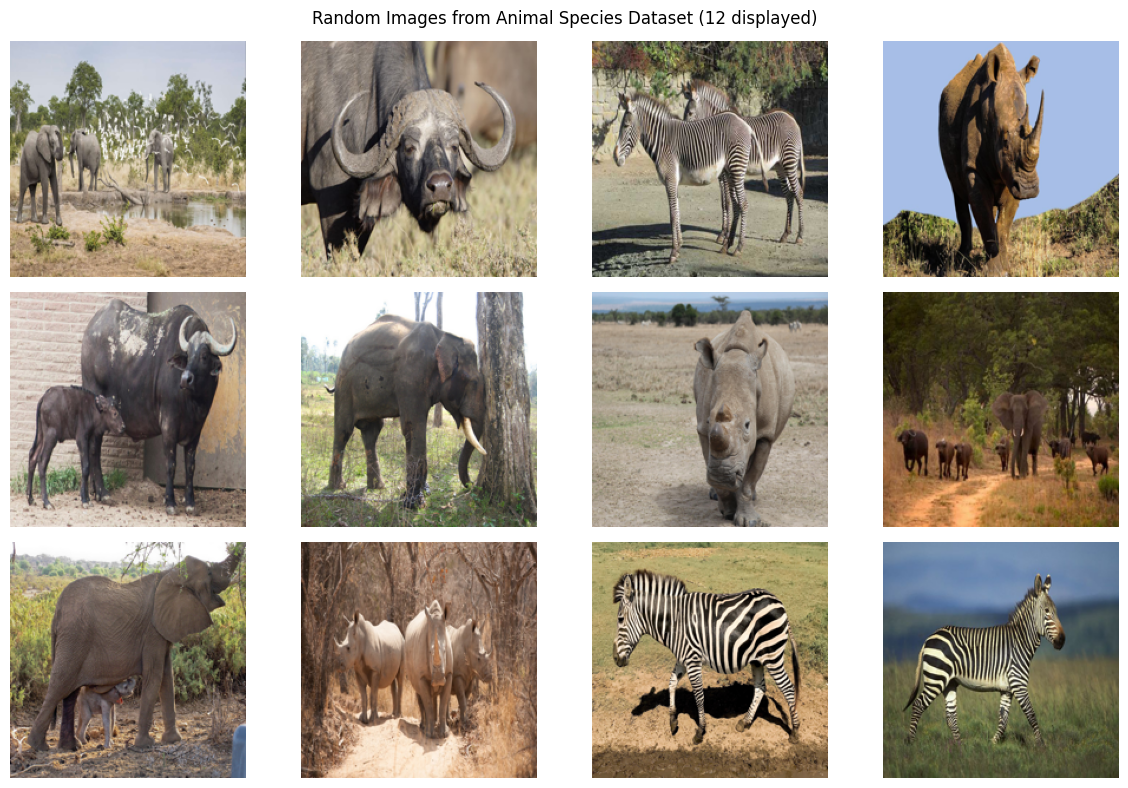

In [21]:
import os
import random
from PIL import Image

# Define paths and number of images
original_dataset_path = '/content/drive/MyDrive/Animal_species'
num_images_to_display = 12  # Increased to display 12 images
desired_size = (200, 200)

# Function to ensure images from different species
def get_unique_species_images(image_paths, num_images):
  # Dictionary to store encountered species and their image count
  species_counts = {}
  unique_images = []
  for image_path in image_paths:
    # Extract species name from path (assuming path structure reflects species)
    species_name = os.path.basename(os.path.dirname(image_path))
    if species_name not in species_counts or species_counts[species_name] < num_images // len(species_counts):
      unique_images.append(image_path)
      species_counts[species_name] = species_counts.get(species_name, 0) + 1
    if len(unique_images) == num_images:
      break
  return unique_images

# Get all image paths
all_image_paths = []
for root, _, files in os.walk(original_dataset_path):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)
            all_image_paths.append(image_path)

# Randomly select images with unique species representation
random_images = get_unique_species_images(random.sample(all_image_paths, len(all_image_paths)), num_images_to_display)

# Process and display images
resized_images = []
for image_path in random_images:
    try:
        img = Image.open(image_path)
        if desired_size:
            img = img.resize(desired_size)
        resized_images.append(img)
    except Exception as e:
        print(f"Error processing image: {image_path} ({e})")

import matplotlib.pyplot as plt
rows, cols = 3, 4  # Adjust rows and columns for desired layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))  # Adjust figure size as needed

for i, img in enumerate(resized_images):
  row, col = divmod(i, cols)
  axes[row, col].imshow(img)
  axes[row, col].axis('off')  # Hide axes for cleaner display

fig.suptitle(f"Random Images from Animal Species Dataset ({len(resized_images)} displayed)")
plt.tight_layout()
plt.show()

## Data Preprocessing

In [12]:
# Define image size and batch size
IMG_SIZE = 300
BATCH_SIZE = 16

# Define data transformations
mean = [0.485, 0.456, 0.406]  # Adjust these values if needed based on your dataset
std = [0.229, 0.224, 0.225]  # Adjust these values if needed based on your dataset

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model Development

In [13]:
#Model Development
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the number of classes in your image classification problem
num_classes = len(os.listdir(train_dir))  # Assuming subdirectories represent classes

model = models.efficientnet_b2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 60.6MB/s]


## Model Training & Fine Tuning

In [14]:
# 6. Model Training
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }

    return model, history

model, history = train_model(model, criterion, optimizer, num_epochs=25)

# Unfreeze the base model for fine-tuning
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)
model, history_fine = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/24
----------
train Loss: 0.5403 Acc: 0.7994
val Loss: 0.1913 Acc: 0.9354

Epoch 1/24
----------
train Loss: 0.4534 Acc: 0.8422
val Loss: 0.0970 Acc: 0.9864

Epoch 2/24
----------
train Loss: 0.3953 Acc: 0.8584
val Loss: 0.1285 Acc: 0.9592

Epoch 3/24
----------
train Loss: 0.3399 Acc: 0.8736
val Loss: 0.2275 Acc: 0.9286

Epoch 4/24
----------
train Loss: 0.2933 Acc: 0.9002
val Loss: 0.1269 Acc: 0.9592

Epoch 5/24
----------
train Loss: 0.3017 Acc: 0.8859
val Loss: 0.0545 Acc: 0.9898

Epoch 6/24
----------
train Loss: 0.2380 Acc: 0.9116
val Loss: 0.0521 Acc: 0.9796

Epoch 7/24
----------
train Loss: 0.3299 Acc: 0.8850
val Loss: 0.0765 Acc: 0.9728

Epoch 8/24
----------
train Loss: 0.2677 Acc: 0.9078
val Loss: 0.0787 Acc: 0.9694

Epoch 9/24
----------
train Loss: 0.2388 Acc: 0.9154
val Loss: 0.0883 Acc: 0.9762

Epoch 10/24
----------
train Loss: 0.2096 Acc: 0.9211
val Loss: 0.0568 Acc: 0.9762

Epoch 11/24
----------
train Loss: 0.2687 Acc: 0.9106
val Loss: 0.0489 Acc: 0.9898

Ep

## Model Evaluation

In [15]:
# Model Evaluation comes after the model training
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the validation images: {accuracy:.2f}%')

evaluate_model(model, val_loader)
evaluate_model(model, test_loader)

Accuracy of the network on the validation images: 99.32%
Accuracy of the network on the validation images: 100.00%


## Plotting the Training and Validation Accuracy and Loss

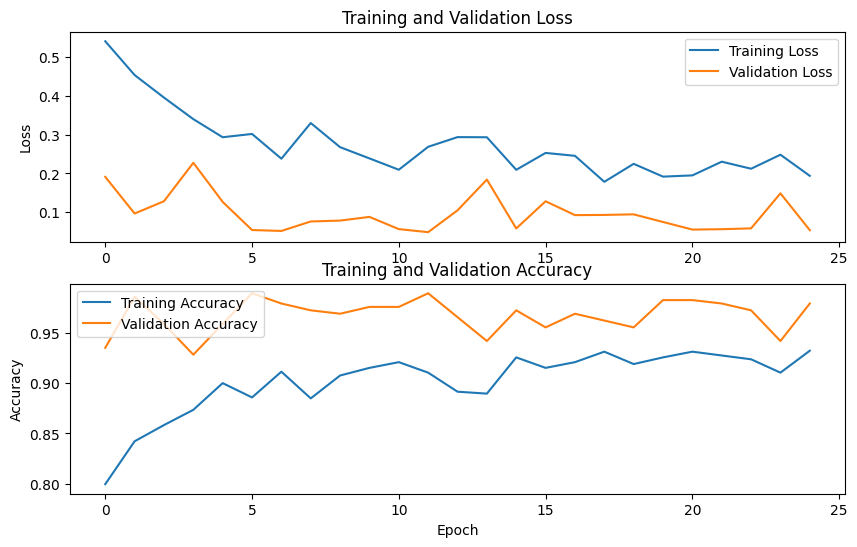

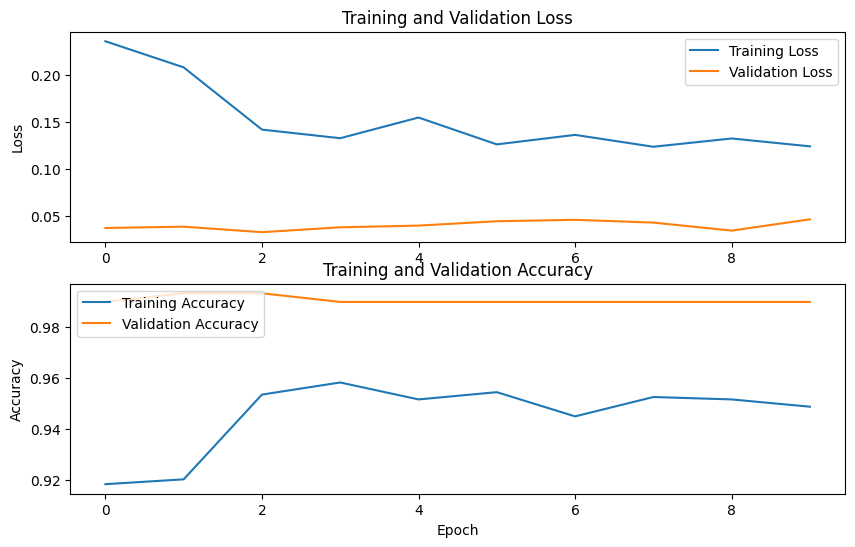

In [24]:
# Plotting the Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.show()

plot_training_history(history)
plot_training_history(history_fine)

## Prediction / Detection Function - Testing Model

In [ ]:

from PIL import Image
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

# Define the device based on the availability of a GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define class names (Adjust based on your dataset)
class_names = ['buffalo', 'zebra', 'rhino', 'elephant']

def predict_image(image_path, model, class_names):
    image = Image.open(image_path).convert('RGB')
    image = test_transforms(image).unsqueeze(0)
    image = image.to(DEVICE)


    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Define the upload function
def upload_and_predict(change):
    # Load the uploaded image file
    file_path = list(uploaded_file_widget.value.keys())[0]
    content = uploaded_file_widget.value[file_path]['content']

    # Save the uploaded file to a temporary location
    temp_image_path = '/tmp/temp_image.jpg'
    with open(temp_image_path, 'wb') as f:
        f.write(content)

    # Predict the class
    predicted_class = predict_image(temp_image_path, model, class_names)
    print(f'Predicted Class: {predicted_class}')

# Create an upload button
uploaded_file_widget = widgets.FileUpload(accept='image/*', multiple=False)
uploaded_file_widget.observe(upload_and_predict, names='value')
display(uploaded_file_widget)
